In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys, warnings, json, glob, tables
from pathlib import Path
path = str(Path(os.path.join('..','src','elohim','elohim')).resolve())
if path not in sys.path:
    sys.path.insert(0,path)
import numpy as np

In [4]:
d_path = sorted(glob.glob('../history/dataset'))
print(np.array(d_path))
d_path = d_path[-1]
d_path

['../history/dataset']


'../history/dataset'

In [130]:
from dataset_ml import get_dataset
from models import initialize_model
batch_size=32
bayes=True
samples=10
model, batch_size, device, _ = initialize_model(batch_size, samples=samples, 
                                                weights_path=os.path.join('../history/0112-1149_orange-fox_b10','training_100','checkpoint.pt'))

(train_dataframe, _, test_dataframe), (train_loader, val_loader, test_loader) = get_dataset(d_path, batch_size=batch_size,
                                                                                   shuffle_train=True)

Loading splits pickles into memory:   0%|          | 0/3 [00:00<?, ?it/s]

This bayesian network will sample 10 times
Using device: cpu
Weights loaded successfully


Loading splits pickles into memory: 100%|██████████| 3/3 [00:17<00:00,  5.92s/it]


Batches per split: 6026,757,758
Datasets x,y shapes [32, 3, 60, 80],[32, 400]


In [131]:
df = test_dataframe.iloc[:500].copy()
tr = transform_function(bayes)
images = df['image'].apply(tr).values.tolist()

In [150]:
from utils import predictions_from_dataframe
from dataset_ml import transform_function
pred, entr, mutu = predictions_from_dataframe(model, df, batch_size, 'cpu', bayes, tr, target_column='image')
pred

Computing predictions (batch size: 32): 100%|██████████| 16/16 [00:22<00:00,  1.43s/it]


time
2020-12-31 06:00:43.414308951    [[0.000663703540340066, 0.001248071203008294, ...
2020-12-31 06:00:43.544252377    [[0.0005756360478699207, 0.0009668426355347037...
2020-12-31 06:00:43.673875524    [[0.0008228986407630146, 0.0014186401385813951...
2020-12-31 06:00:43.806099740    [[0.0007398290908895433, 0.0012223718222230673...
2020-12-31 06:00:43.949390087    [[0.0008027025614865124, 0.0014261684846132994...
                                                       ...                        
2020-12-31 06:01:51.304882906    [[0.0214394461363554, 0.03214706853032112, 0.0...
2020-12-31 06:01:51.437166875    [[0.0214394461363554, 0.03214706853032112, 0.0...
2020-12-31 06:01:51.566072439    [[0.04433906823396683, 0.05686337873339653, 0....
2020-12-31 06:01:51.696304534    [[0.02935720607638359, 0.02829243615269661, 0....
2020-12-31 06:01:51.825505355    [[0.017224803566932678, 0.01270376332104206, 0...
Length: 500, dtype: object

In [165]:
from utils import COORDS
from config import SENSORS
from occupancy_map import compute_occupancy_map
from tqdm import tqdm
tqdm.pandas()
df['target_map'] = df.groupby('big_block').apply(
        lambda x: x.progress_apply(compute_occupancy_map, axis=1, args=(x, COORDS, SENSORS, f'10s', 0.04)))

/usr/local/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 1/1 [00:23<00:00, 23.28s/it]


array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0., -1., -1., -1., -1., -1., -1., -1., -1., -1

In [176]:
import matplotlib.colors as clr
cmap = clr.LinearSegmentedColormap.from_list('diverging map', [(0, 'grey'), (0.5, (0, 1, 0)), (1, (1, 0, 0))], N=256)
pred2 = [cmap(x.reshape(20,20)) for x in df['target_map'].values]
# cmap =clr.LinearSegmentedColormap.from_list('diverging map', [(0, 'grey'), (0.5, 'red'), (1, 'yellow')], N=256)
# pred = [cmap(x) for x in pred]


pred2 = []
for x in df['target_map'].values:
    x = x.reshape(20,20)
    res = np.empty((20, 20, 3), dtype=np.uint8)
    res[x == -1] = (190, 190, 190)
    res[x == 0] = (0, 255, 0)
    res[x == 1] = (255, 0, 0)
    pred2.append(res)

(-0.5, 19.5, 19.5, -0.5)

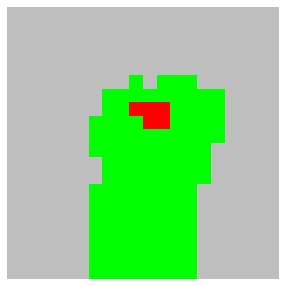

In [177]:
fig, axs = plt.subplots(figsize=(5,5))
axs.imshow(pred2[200::20][int(n/2)])
axs.axis('off')



In [178]:
!pwd

/Users/ste/code/active_learning/notebooks


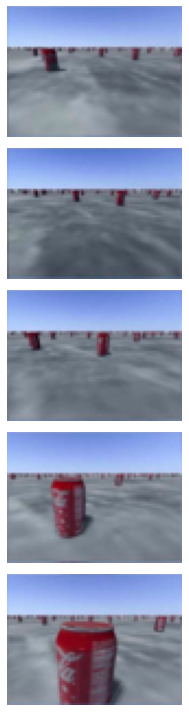

In [139]:
n = 5
import seaborn as sns
import matplotlib.pyplot as plt
fig, axs = plt.subplots(n, figsize=(3,10), dpi=150)
for ax, o in zip(axs, images[200::20][:n]):
    X2 = np.moveaxis(o.detach().numpy(),0,-1)
    X2 = (X2 - X2.min()) / (X2.max() - X2.min())
    ax.imshow(X2)
    ax.axis('off')
plt.tight_layout()
plt.savefig('5images.png')